In [178]:
# Import necessary libraries
import gempy as gp
import gempy_viewer as gpv
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import os
import verde as vd
from gempy_engine.core.data.centered_grid import CenteredGrid
import gemgis as gg
import pyvista as pv
from disba import PhaseDispersion,EigenFunction,PhaseSensitivity

import time, array

from deap import base, creator, tools, algorithms
from scipy.interpolate import interp1d
import vtk

# Functions 

## Modelling 


$V_p = \left( \frac{\rho}{0.23} \right)^4 . 0.3048$


In [96]:
# Function to estimate the P and S velocities and Poisson ration in function of initial density
def calculate_parameters(densities):
    '''
    Vp = ((Density\0.23)**4)*0.3048
    Vs = Vp/sqrt(3)
    '''
    
    vp = ((densities/310)**4)*0.3048 #gardner
    vs = vp / np.sqrt(3)
    
    return vp,vs


# Function to estimate the P velocities and Densities in function of initial density
def calculate_parameters_from_vs(vel_s):
    '''
    Vp = ((Density\0.23)**4)*0.3048
    Vs = Vp/sqrt(3)
    '''
    
    vp = vel_s * np.sqrt(3)

    densities = 310*((vp/0.3048)**(1/4))

    return vp,densities
    

# Function to generate a complete seismic model with random variation at each point
def create_complete_seismic_model(xi,yj,num_layers):
    '''
    xi: numpy.ndarray region [west-east points]) with a specific spacing (100 units in this case).
    yj: numpy.ndarray region [south-north points]) with a specific spacing (100 units in this case).
    num_layers: Number of layers of the model 
    '''
    
    # Initialize lists to store the variations of each parameter for each receiver
    x_l = []
    y_l = []
    depths = []
    vp = []
    vs = []
    densities = []
    formation = []
    
    # Define variation ranges for each layer
    depth_ranges = [(-0.1, -0.5), (-0.5, -1.0), (-1.0, -1.5),(-2.0, -2.0)]
    #depth_ranges = [(-0.5, -0.5), (-1.0, -1.0), (-1.5, -1.5),(-2.0, -2.0)]
    density_ranges = [(1000, 1100), (1200, 1300), (1500, 1700),(1800, 2000)]
    
    for l in range(num_layers):
        x_l.append(xi)
        y_l.append(yj)
        
        # Generate random variations for each layer
        depths.append(np.random.uniform(*depth_ranges[l], size=xi.shape))
        densi = np.random.uniform(*density_ranges[l], size=yj.shape)
        densities.append(densi)
            
        # Calculate the parameters individually for each point
        vp.append(calculate_parameters(densi)[0])
        vs.append(calculate_parameters(densi)[1])

        formation.append('soil'+str(l+1))

    # last layer - ROCK
    x_l.append(xi)
    y_l.append(yj)
        
    # Generate random variations for each layer
    depths.append(np.random.uniform(*depth_ranges[-1], size=xi.shape))
    densi = np.random.uniform(*density_ranges[-1], size=yj.shape)
    densities.append(densi)
            
    # Calculate the parameters individually for each point
    vp.append(calculate_parameters(densi)[0])
    vs.append(calculate_parameters(densi)[1])

    formation.append('basement')

    # Salvar modelo e dados
    model = {
        'xi':x_l,
        'yj':y_l,
        'vp': vp,
        'vs': vs,
        'depths': depths,
        'densities': densities,
        'num_layers': num_layers,
        'formation': formation,
    }

    return model

## Dispersion curve estimation

In [164]:
uniform(0.0001,0.0005,20,150,4)[1][0]

147.5979116677268

In [170]:
def create_velocity_model_from_profile(model_profile):

    dens_values_unique,dens_index_unique = np.unique(model_profile,return_index=True)

    dens_index_unique = sorted(dens_index_unique)

    depth_ = np.linspace(0,-2.,len(model_profile)+1)

    thickness_ = [depth_[i] for i in dens_index_unique]
    thickness_.append(-2.0)

    thickness = np.diff(thickness_)*(-1)

    dens = model_profile[dens_index_unique]

    vp, vs = calculate_parameters(dens)

    vmodel = []
    for idx in range(len(dens)):

        # thickness, Vp, Vs, density
        # km, km/s, km/s, g/cm3        

        if idx == len(dens_values_unique)-1:
            vmodel.append([0.0,vp[idx]/1000,vs[idx]/1000,dens[idx]/1000])
        else:
            vmodel.append([thickness[idx]/1000,vp[idx]/1000,vs[idx]/1000,dens[idx]/1000])
   
    velocity_model = np.array(vmodel)    

    return velocity_model

def create_velocity_model_from_profile_vs(model_profile):
    
    vmodel = []
    for (thickness,vs) in zip(*model_profile):
 
        vp, dens = calculate_parameters_from_vs(vs)
        
        # thickness, Vp, Vs, density
        # km, km/s, km/s, g/cm3

        if thickness == model_profile[-1][0]:
            vmodel.append([0.0,vp/1000,vs/1000,dens/1000])
        else:
            vmodel.append([thickness/1000,vp/1000,vs/1000,dens/1000])
   
    velocity_model = np.array(vmodel)    

    return velocity_model

def estimate_disp_from_velocity_model(vel_mol,number_samples=100):
    # Periods must be sorted starting with low periods
    hz = np.linspace(1, 100.0, number_samples) # Hertz
    
    t = 1/hz[::-1] # Hertz to seconds
    
    # Fundamental mode corresponds to mode 0
    pdisp = PhaseDispersion(*vel_mol.T,dc=0.001)

    cpr = pdisp(t, mode=0, wave="rayleigh")

    return cpr    

# Code

In [34]:
data_path = 'data/'

In [35]:
glob.glob(data_path+'/*')

['data/points.csv',
 'data/orientations.csv',
 'data/density_block.vtk',
 'data/density_block.npy']

In [36]:
spacing = 25

west, east, south, north = 0, 100, 0, 100
region = (west, east, south, north)

# create the grid coordinates
X,Y = vd.grid_coordinates(region=region, spacing=spacing)

In [37]:

# Função principal
num_layers = 3
model = create_complete_seismic_model(xi=X,yj=Y,num_layers=num_layers)

Text(0, 0.5, 'Northing')

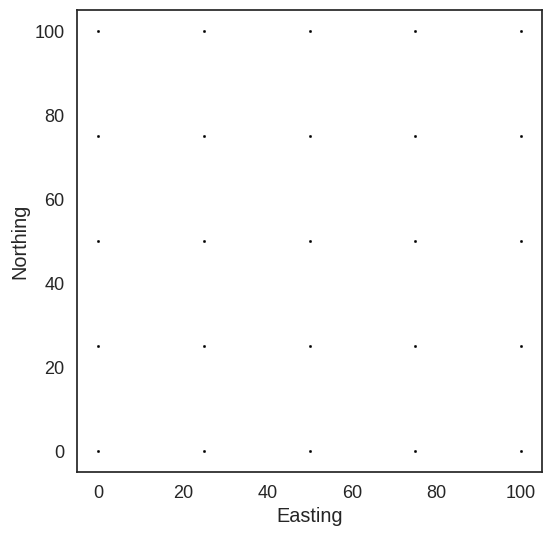

In [38]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
ax.scatter(X,Y,s=10,c='k',marker='.')

plt.xlabel("Easting")
plt.ylabel("Northing")

In [39]:
lst_soils = []
for l in range(num_layers+1):
    for k in range(len(model['xi'][l].ravel())):
            lst_soils.append({'X':model['xi'][l].ravel()[k], 'Y':model['yj'][l].ravel()[k], 'Z':model['depths'][l].ravel()[k], 'formation':model['formation'][l]})

In [40]:
soils_df = pd.DataFrame.from_dict(data=lst_soils)

In [41]:
soils_df

,X,Y,Z,formation
0,0.00,0.00,-0.40,soil1
1,25.00,0.00,-0.44,soil1
2,50.00,0.00,-0.29,soil1
3,75.00,0.00,-0.12,soil1
4,100.00,0.00,-0.44,soil1
...,...,...,...,...
95,0.00,100.00,-2.00,basement
96,25.00,100.00,-2.00,basement
97,50.00,100.00,-2.00,basement
98,75.00,100.00,-2.00,basement


In [42]:
os.remove('data/points.csv')
soils_df.to_csv('data/points.csv', header=soils_df.columns, index=None, sep=',', mode='a')

In [43]:
lst_soils_orient = []
for l in range(num_layers+1):
    for k in range(len(model['xi'][l].ravel()[::5])):
            lst_soils_orient.append({'X':model['xi'][l].ravel()[k]*0.75, 'Y':model['yj'][l].ravel()[k]*0.75, 'Z':model['depths'][l].ravel()[k]*0.9, 'formation':model['formation'][l],'Azimuth':0,'Dip':0,'Polarity':1})

soils_orient_df = pd.DataFrame.from_dict(data=lst_soils_orient)

In [44]:
soils_orient_df

,X,Y,Z,formation,Azimuth,Dip,Polarity
0,0.00,0.00,-0.36,soil1,0,0,1
1,18.75,0.00,-0.39,soil1,0,0,1
2,37.50,0.00,-0.26,soil1,0,0,1
3,56.25,0.00,-0.11,soil1,0,0,1
4,75.00,0.00,-0.40,soil1,0,0,1
5,0.00,0.00,-0.49,soil2,0,0,1
6,18.75,0.00,-0.89,soil2,0,0,1
7,37.50,0.00,-0.79,soil2,0,0,1
8,56.25,0.00,-0.52,soil2,0,0,1
9,75.00,0.00,-0.70,soil2,0,0,1


In [45]:
os.remove('data/orientations.csv')
soils_orient_df.to_csv('data/orientations.csv', header=soils_orient_df.columns, index=None, sep=',', mode='a')


In [46]:
density_grid = np.concatenate(model['densities'])

depth_grid = np.concatenate(model['depths'])

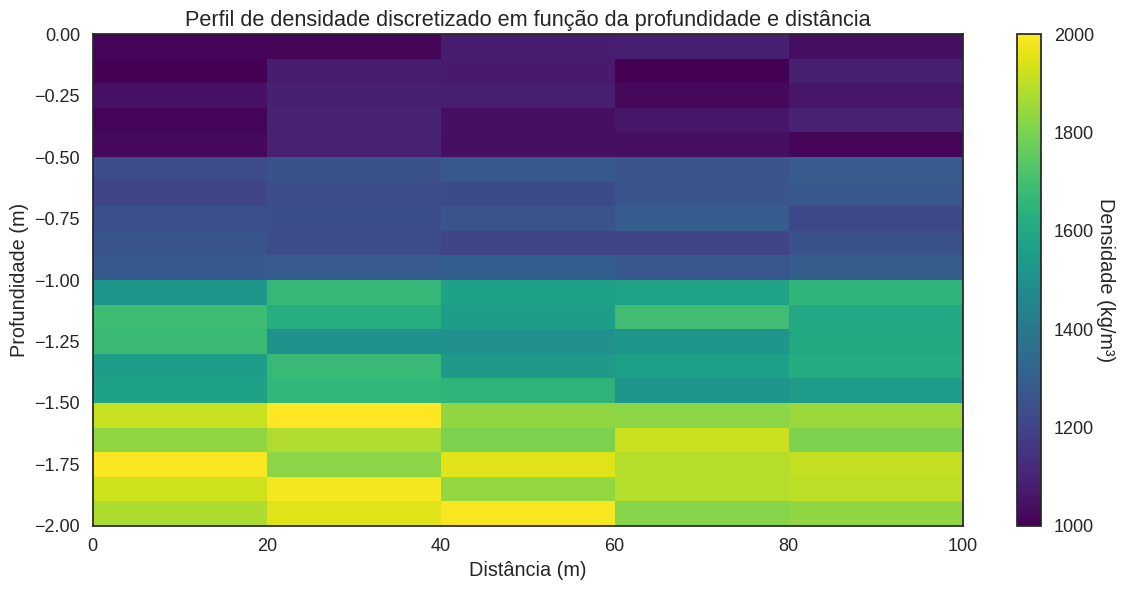

In [47]:
# Plotar o perfil de densidade ajustado
fig, ax = plt.subplots(figsize=(12, 6))
cmap = plt.get_cmap("viridis")
norm = mcolors.Normalize(vmin=1000, vmax=2000)
extent = [0, 100, -2, 0]
cax = ax.imshow(density_grid, extent=extent, origin='upper', cmap=cmap, aspect='auto', norm=norm)

# Adicionar barra de cores
cbar = fig.colorbar(cax)
cbar.set_label('Densidade (kg/m³)', rotation=270, labelpad=15)

# Configurações do gráfico
ax.set_xlabel('Distância (m)')
ax.set_ylabel('Profundidade (m)')
ax.set_title('Perfil de densidade discretizado em função da profundidade e distância')

# Ajustar layout e salvar o gráfico
plt.tight_layout()
plt.savefig('perfil_densidade_discretizado.png', dpi=300)
plt.show()

In [48]:
# Create a GeoModel instance

grid_reso = 50
# Dados do modelo
extent = [0, 100, 0, 100, -2,0]  # [x_min, x_max, y_min, y_max, z_min, z_max]
resolution = [grid_reso,grid_reso,int(grid_reso/2)]  # Resolução do grid


data = gp.create_geomodel(
    project_name='soil_horizontal',
    extent=extent,
    resolution=resolution,
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations=data_path + "/orientations.csv",
        path_to_surface_points=data_path + "/points.csv"
    )
)


In [49]:
# Compute the geological mode
gp.compute_model(data)
geo_data = data

Setting Backend To: AvailableBackends.numpy
Chunking done: 20 chunks
Chunking done: 8 chunks


In [50]:
# Define structural groups and age/stratigraphic relationship
gp.map_stack_to_surfaces(
    gempy_model=geo_data,
    mapping_object={
        "Strat_Series1": tuple(soils_orient_df.formation.unique().tolist())
    }
)

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=Strat_Series1,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=soil1,
	color=#9f0052,
	is_active=True
),
Element(
	name=soil2,
	color=#ffbe00,
	is_active=True
),
Element(
	name=soil3,
	color=#728f02,
	is_active=True
),
Element(
	name=basement,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

In [51]:
gp.compute_model(geo_data)

Setting Backend To: AvailableBackends.numpy
Chunking done: 20 chunks
Chunking done: 8 chunks


Solutions(4 Octree Levels, 4 DualContouringMeshes)

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


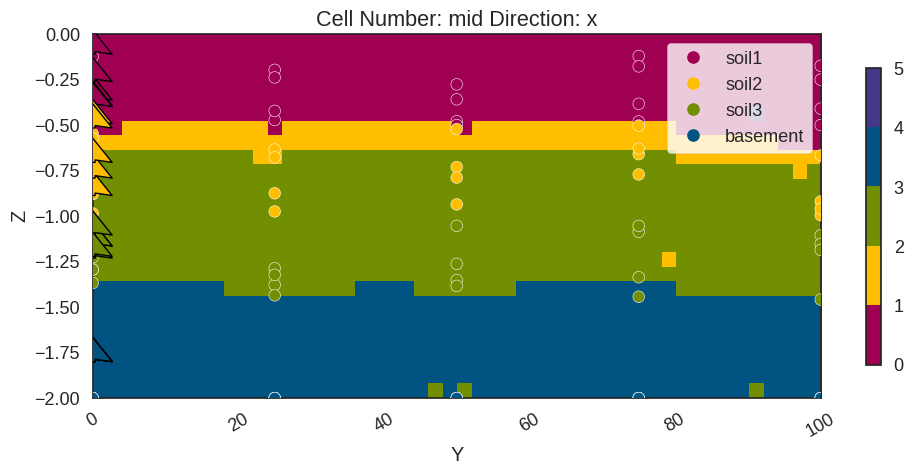

In [52]:
# Plot the result of the model in the x and y direction with data and without boundaries
gpv.plot_2d(geo_data, direction=['x'],ve=25, show_data=True, show_boundaries=True)

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


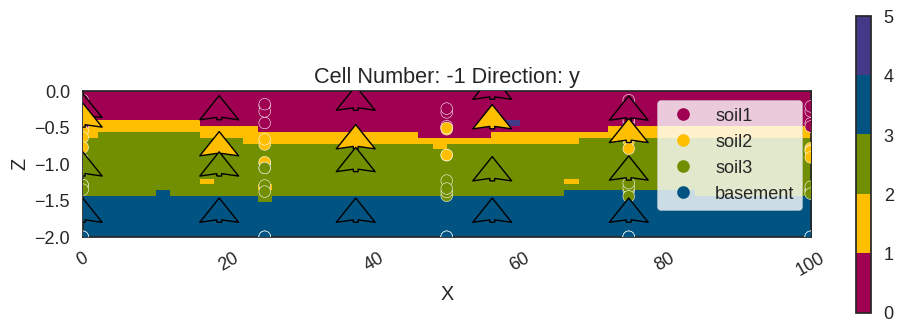

In [53]:
gpv.plot_2d(geo_data, cell_number=[-1], direction=['y'],ve=10, show=True,kwargs_regular_grid={'alpha': .5})

In [54]:
gempy_plot = gpv.plot_3d(
    model=geo_data,
    show_scalar=False,
    ve=10,
    show=False,
    image=False,
    transformed_data=False,
    kwargs_pyvista_bounds={
            'show_xlabels': False,
            'show_ylabels': False,
            'show_zlabels': True,
            'show_xaxis': False,
            'show_yaxis': False,
    },
    kwargs_plot_data={
            'arrow_size': 40.0
    }
)



gempy_plot.p.show()

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


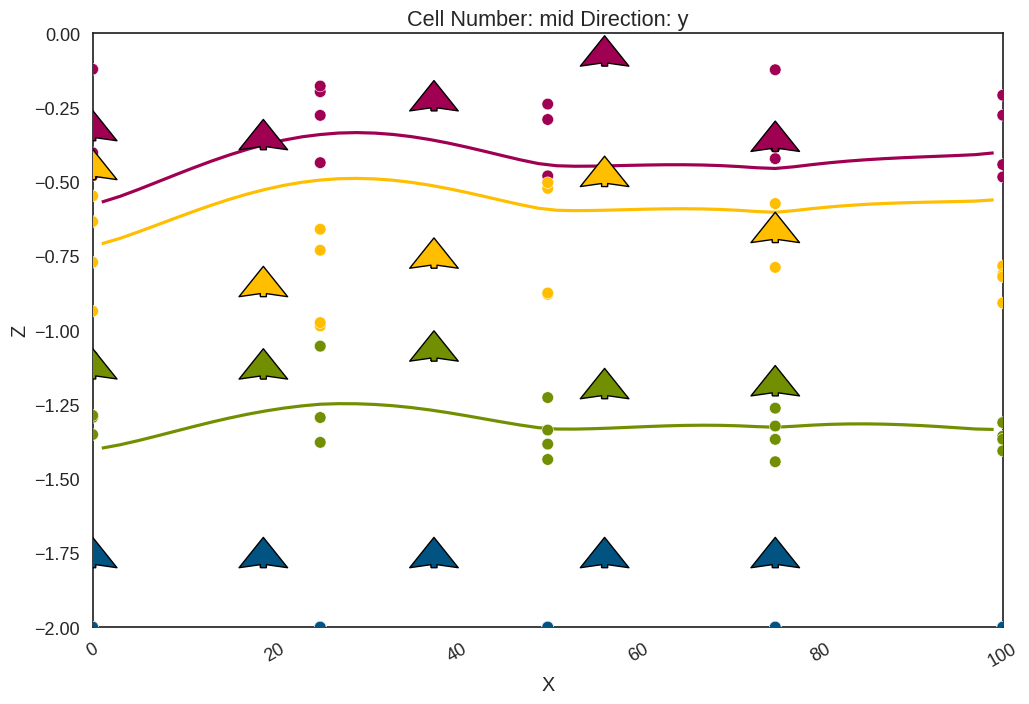

In [55]:
gpv.plot_2d(geo_data, show_value=False, show_lith=False, show_scalar=False,legend=False, cell_number='mid')

In [56]:
lith_block = geo_data.solutions.raw_arrays.lith_block.reshape(grid_reso,grid_reso,int(grid_reso/2))
lith_block.shape

(50, 50, 25)

In [57]:
np.unique(geo_data.solutions.raw_arrays.lith_block)

array([1, 2, 3, 4, 5], dtype=int8)

In [58]:
density_values = [np.mean(i) for i in model['densities']]

In [59]:
density_dict = {k: v for k,v in zip(np.unique(np.round(lith_block)), density_values)}
density_dict

{1: 1051.8033133469842,
 2: 1253.5385423172627,
 3: 1596.263981700736,
 4: 1889.8700681149016}

In [60]:
density_block = gg.utils.assign_properties(lith_block=lith_block, property_dict=density_dict)

In [61]:
np.save('data/density_block.npy', density_block)

In [62]:
volume = pv.wrap(density_block)

In [63]:
volume.save('data/density_block.vtk',binary=True)

# DISBA - surface wave dispersion

In [64]:
density_block.shape

(50, 50, 25)

In [65]:
north/grid_reso

2.0

In [66]:
lst_receptor = np.arange(1, density_block.shape[0]-1,10)

In [67]:
lst_receptor

array([ 1, 11, 21, 31, 41])

In [68]:
line_row = np.random.randint(low=0,high=density_block.shape[0]-1)
line_row

7

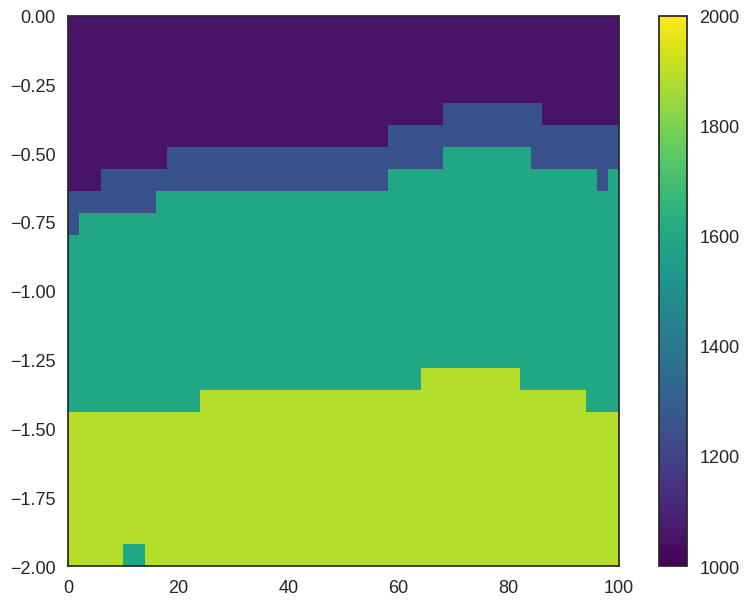

In [69]:
im = plt.imshow(density_block[line_row,:,:].T, cmap='viridis',extent=[0, 100, -2.0, 0],vmin=1000.0,vmax=2000.0,aspect=50,origin='lower')

plt.colorbar(im);

In [70]:
slice_block = density_block[line_row,:,:].T

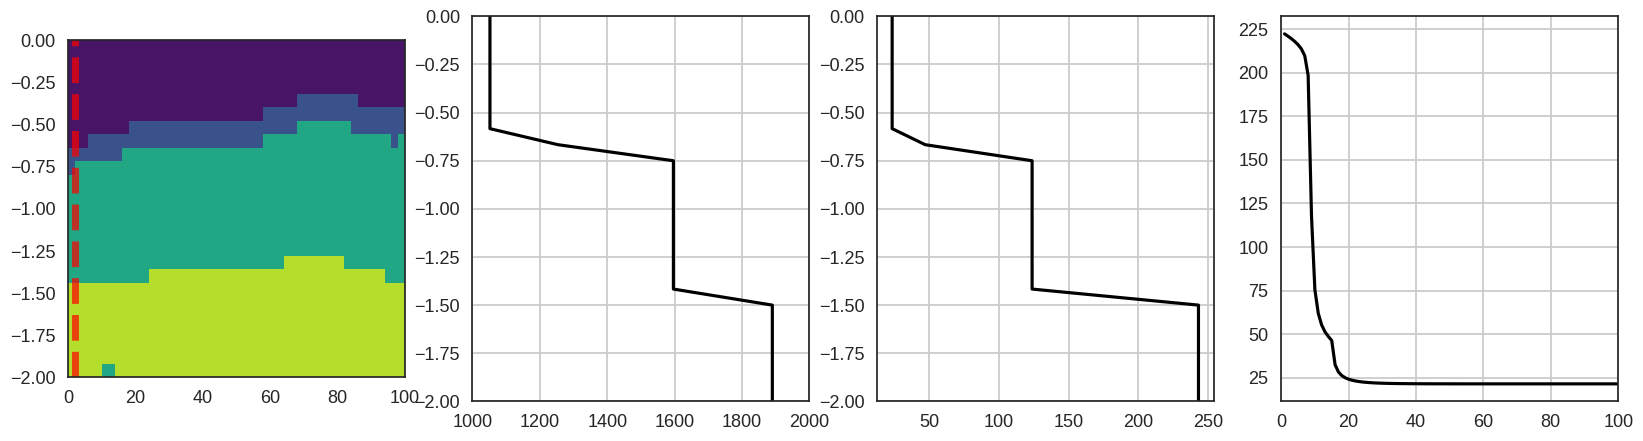

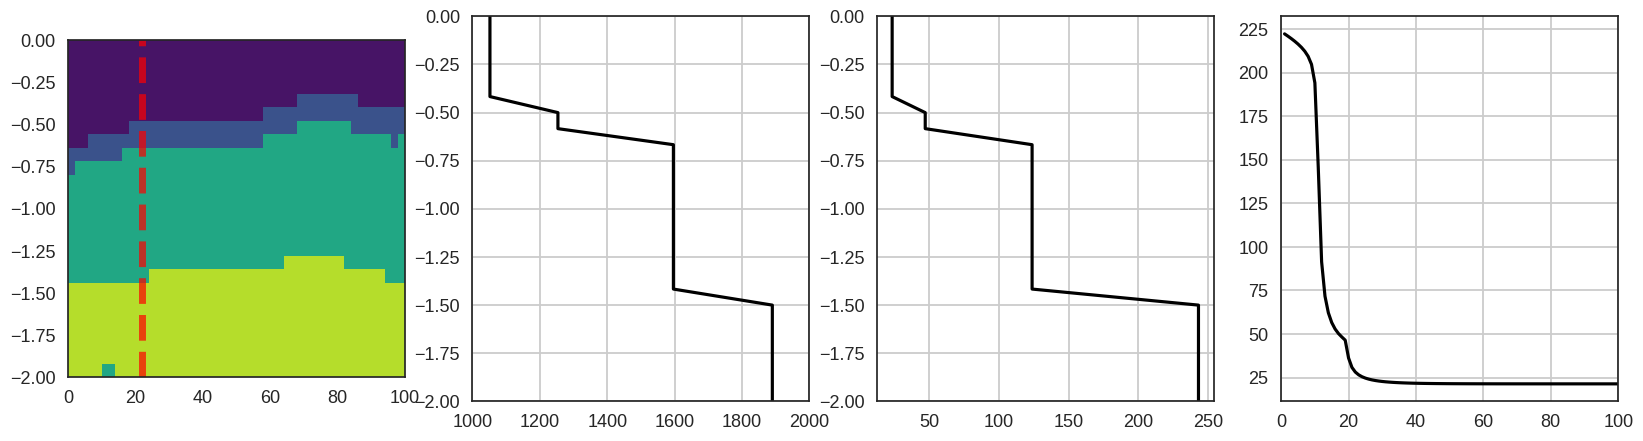

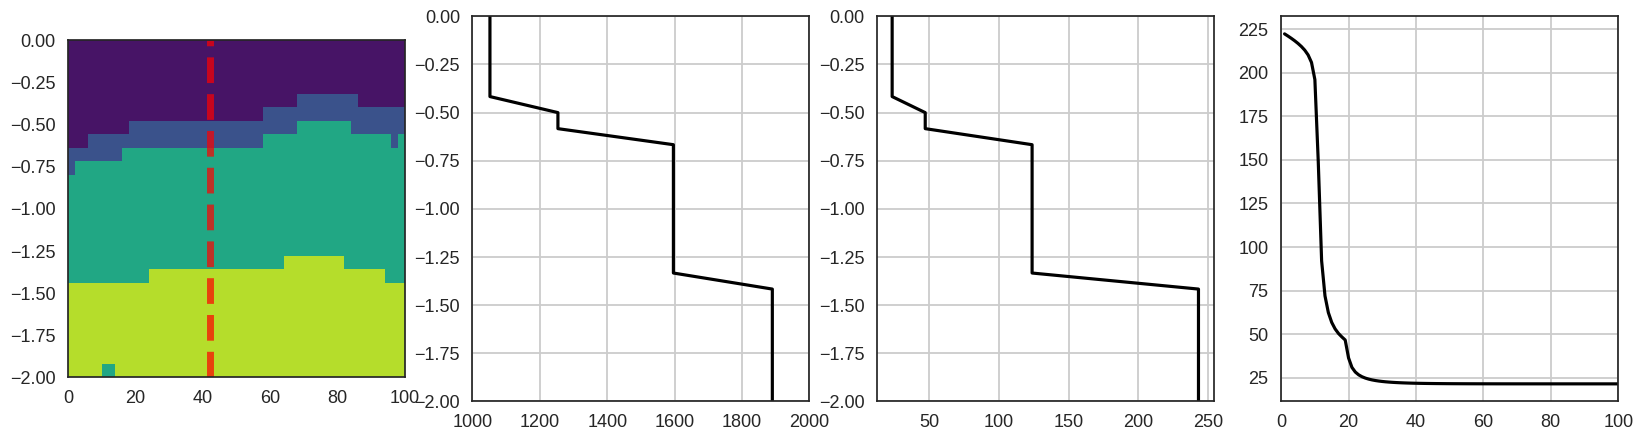

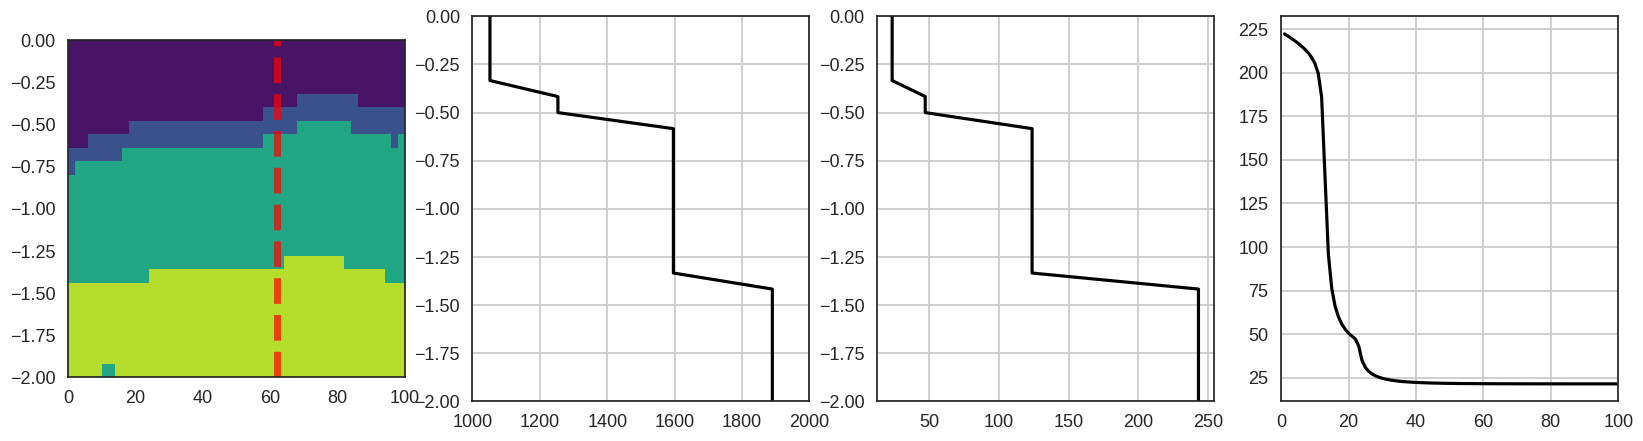

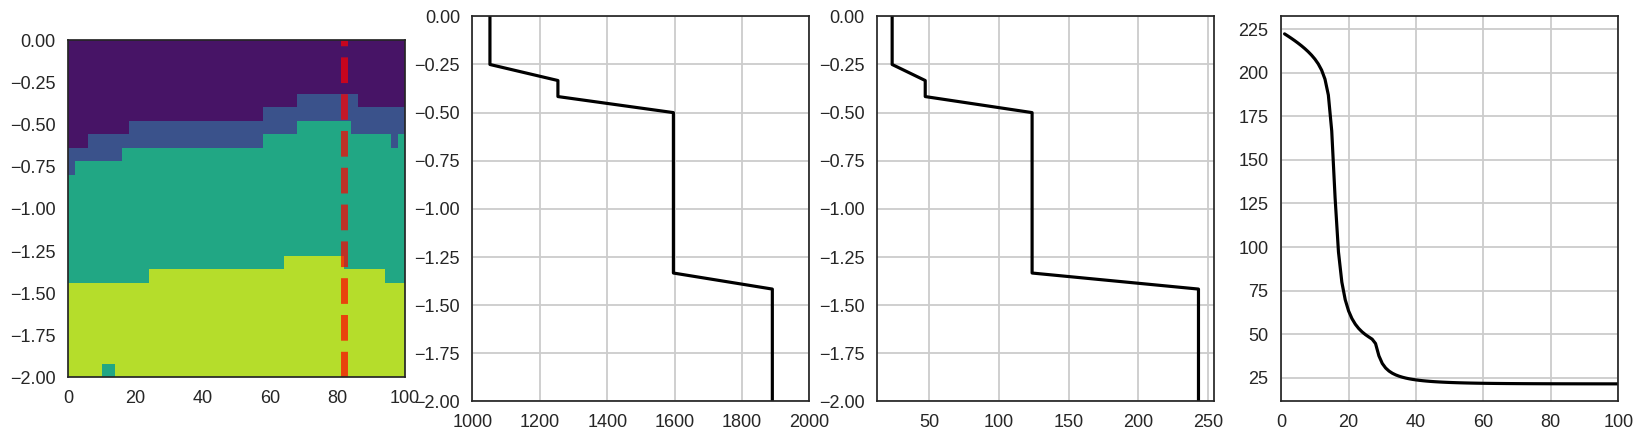

In [72]:
profile_lst = []
dispersion_curve_lst = []

profile_number = np.random.random(size=1)

for ix in lst_receptor:
    fig, (ax, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 5))

    im = ax.imshow(slice_block, cmap='viridis',extent=[0, 100, -2.0, 0],vmin=1000.0,vmax=2000.0,aspect=50,origin='lower')
    ax.vlines(x=ix*(north/grid_reso),ymin=-2.0,ymax=0,colors='r',lw=5.0,ls='--',alpha=0.7)

    profile_lst.append(slice_block[:,ix])
    ax1.plot(slice_block[:,ix],np.linspace(-2., 0,len(slice_block[:,ix])),'-k')
    ax1.set_xlim(1000.0,2000.0)
    ax1.set_ylim(-2.0,0.0)
    ax1.grid('on')
         
    velocity_model = create_velocity_model_from_profile(model_profile=slice_block[:,ix][::-1])

    velocity_p,velocity_s = calculate_parameters(slice_block[:,ix])

    ax2.plot(velocity_s,np.linspace(-2., 0,len(slice_block[:,ix])),'-k')
    ax2.set_ylim(-2.0,0.0)
    ax2.grid('on')    
    
    cpr = estimate_disp_from_velocity_model(velocity_model)  

    dispersion_curve_lst.append(cpr.velocity*1000)
    ax3.plot(1/cpr.period,cpr.velocity*1000,'-k')
    ax3.grid('on')
    #ax3.set_ylim(0,200)
    ax3.set_xlim(0,100)


In [73]:
filename_npy = 'data/density_block.npy'

data_grid = np.load(filename_npy)

In [74]:
data_grid.shape

(50, 50, 25)

In [180]:
def uniform(low_thick, up_thick,low_vels,up_vels, size):
    sis = [i+1 for i in range(size)]
    thickness_lst = []
    vs_lst = []
    for s in sis:
        if s == sis[0]:
            thickness_lst.append(np.random.uniform(low_thick,up_thick))
            vs_lst.append(np.random.uniform(low_vels*s,up_vels*s))
        else:
            thickness_lst.append(np.random.uniform(low_thick,up_thick))
            vs_lst.append(np.random.uniform(low_vels*(s*0.75),up_vels*(s*0.75)))
    return [thickness_lst,vs_lst]

In [181]:
print(uniform(0.0001,0.0005,20,150,4))

[[0.00024780467293573184, 0.00019463129024938465, 0.0003726230580971709, 0.0004443648035951858], [28.99077817336632, 207.849011081967, 209.43693321603743, 414.0105300106563]]


In [184]:
# Variáveis globais para armazenar os valores da função objetivo por iteração
objective_values = []

# Função objetivo para a inversão usando DEAP
def inversion_objective(individual, true_disp):
    for item in individual:

        # Simula a curva de dispersão com base nas velocidades estimadas de Vs (indivíduo) para otimização
        simulated_velocity_model = create_velocity_model_from_profile_vs(item)
    
        simulated_cpr = estimate_disp_from_velocity_model(simulated_velocity_model)
    
        simulated_dispersion = simulated_cpr.velocity*1000
        
        # Calcula o erro como a soma dos quadrados das diferenças entre a curva simulada e a curva estimada
        error = np.sum((simulated_dispersion - true_disp) ** 2)
    
        # Armazenar o valor da função objetivo
        objective_values.append(error)

    return error,

# Configuração da DEAP para otimização evolutiva
def configure_deap(estimated_disp):

    # deap.creator: meta-factory allowing to create classes that will fulfill the needs of your evolutionary algorithms.
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # deap.base.Toolbox: A toolbox for evolution that contains the evolutionary operators. You may populate the toolbox with any other function by using the register() method
    toolbox = base.Toolbox()

    # Attribute generator
    toolbox.register("attr_item", uniform, 0.0001,0.0005,20,150,5)  # Intervalo de velocidades S (Vs)

    # Structure initializers
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_item,n=5)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", inversion_objective, true_disp=estimated_disp)

    # The general rule for crossover operators is that they only mate individuals, 
    # this means that an independent copies must be made prior to mating the individuals 
    # if the original individuals have to be kept or is are references to other individuals (see the selection operator).
    # --> Each crossover has its own characteristics and may be applied to different type of individuals.
    # Lets apply a crossover operation:
    toolbox.register("mate", tools.cxTwoPoint)

    # The general rule for mutation operators is that they only mutate, 
    # this means that an independent copy must be made prior to mutating 
    # the individual if the original individual has to be kept or is a 
    # reference to an other individual (see the selection operator).
    # --> Each mutation has its own characteristics and may be applied to different type of individual.
    # In order to apply a mutation (here a gaussian mutation) on the individual ind1, simply apply the desired function.
    toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=1, indpb=0.2)
    
    # Selection is made among a population by the selection operators that are available in the deap.operators module.
    # The selection operator usually takes as first argument an iterable container of individuals and the number of individuals to select. 
    # It returns a list containing the references to the selected individuals.
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    return toolbox

# Função principal para rodar a inversão
def run_inversion():
    # Carregar as velocidades estimadas 
    estimated_disp = dispersion_curve_lst[0]

    # Configurar DEAP
    toolbox = configure_deap(estimated_disp)

    # Realizar a evolução (inversão) usando algoritmo genético
    pop = toolbox.population(n=50)
    CXPB, MUTPB, NGEN = 0.5, 0.2, 40


    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit


    for g in range(50):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring

    return pop

    # Extrair o melhor indivíduo após a evolução
    best_individual = tools.selBest(population, k=1)[0]

    # Plotar resultados
    #plot_inverted_vs_profile(best_individual, depths)
    plot_convergence()

# Função para plotar o perfil invertido de Vs
def plot_inverted_vs_profile(velocities, depths):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.step(velocities, depths, where='post', color='b', linewidth=2, label=f'Modelo final após {len(objective_values)} iterações')
    ax.set_title('Perfil de velocidade Vs em função da profundidade (Evolutionary Algorithms)')
    ax.set_xlabel('Velocidade da onda S (m/s)')
    ax.set_ylabel('Profundidade (m)')
    ax.invert_yaxis()  # Inverter eixo Y para profundidade aumentar para baixo
    ax.grid(True)
    plt.tight_layout()
    ax.minorticks_on()
    ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

    plt.savefig('perfil_vs_invertido.png', dpi=300)
    plt.show()

# Função para plotar a convergência da função objetivo
def plot_convergence():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(objective_values, label='Função objetivo por iteração', color='blue')
    ax.set_title('Convergência da função objetivo')
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Valor da função objetivo')
    ax.axvline(x=len(objective_values)-1, color='red', linestyle='--', label='Última iteração')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    ax.minorticks_on()
    ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

    plt.savefig('convergencia_funcao_objetivo.png', dpi=300)
    plt.show()

# Executar o processo de inversão
if __name__ == "__main__":
    run_inversion()

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


TypeError: 'float' object is not iterable

In [ ]:
# Variáveis globais para armazenar os valores da função objetivo por iteração
objective_values = []

# Função objetivo para a inversão usando DEAP
def inversion_objective(individual, true_disp):

    # Simula a curva de dispersão com base nas velocidades estimadas de Vs (indivíduo) para otimização
    simulated_velocity_model = create_velocity_model_from_profile_vs(individual)

    print(simulated_velocity_model)

    simulated_cpr = estimate_disp_from_velocity_model(simulated_velocity_model)

    simulated_dispersion = simulated_cpr.velocity*1000
    
    # Calcula o erro como a soma dos quadrados das diferenças entre a curva simulada e a curva estimada
    error = np.sum((simulated_dispersion - true_disp) ** 2)

    # Armazenar o valor da função objetivo
    objective_values.append(error)
    
    return error,

# Configuração da DEAP para otimização evolutiva
def configure_deap(estimated_disp):
    if "FitnessMin" in creator.__dict__:
        del creator.FitnessMin
    if "Individual" in creator.__dict__:
        del creator.Individual

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    
    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.randint, 20, 50)  # Intervalo de velocidades S (Vs)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=5)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", inversion_objective, true_disp=estimated_disp)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    return toolbox

# Função principal para rodar a inversão
def run_inversion():
    # Carregar as velocidades estimadas 
    estimated_disp = dispersion_curve_lst[0]

    # Configurar DEAP
    toolbox = configure_deap(estimated_disp)

    # Realizar a evolução (inversão) usando algoritmo genético
    population = toolbox.population(n=50)
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=True)

    # Extrair o melhor indivíduo após a evolução
    best_individual = tools.selBest(population, k=1)[0]

    # Plotar resultados
    #plot_inverted_vs_profile(best_individual, depths)
    plot_convergence()

# Função para plotar o perfil invertido de Vs
def plot_inverted_vs_profile(velocities, depths):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.step(velocities, depths, where='post', color='b', linewidth=2, label=f'Modelo final após {len(objective_values)} iterações')
    ax.set_title('Perfil de velocidade Vs em função da profundidade (Evolutionary Algorithms)')
    ax.set_xlabel('Velocidade da onda S (m/s)')
    ax.set_ylabel('Profundidade (m)')
    ax.invert_yaxis()  # Inverter eixo Y para profundidade aumentar para baixo
    ax.grid(True)
    plt.tight_layout()
    ax.minorticks_on()
    ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

    plt.savefig('perfil_vs_invertido.png', dpi=300)
    plt.show()

# Função para plotar a convergência da função objetivo
def plot_convergence():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(objective_values, label='Função objetivo por iteração', color='blue')
    ax.set_title('Convergência da função objetivo')
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Valor da função objetivo')
    ax.axvline(x=len(objective_values)-1, color='red', linestyle='--', label='Última iteração')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    ax.minorticks_on()
    ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

    plt.savefig('convergencia_funcao_objetivo.png', dpi=300)
    plt.show()

# Executar o processo de inversão
if __name__ == "__main__":
    run_inversion()

In [ ]:
dispersion_curve_lst[0]

In [ ]:
best_individual

In [91]:
#    This file is part of DEAP.
#
#    DEAP is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    DEAP is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

IND_INIT_SIZE = 5
MAX_ITEM = 50
MAX_WEIGHT = 50
NBR_ITEMS = 20

# To assure reproducibility, the RNG seed is set prior to the items
# dict initialization. It is also seeded in main().
random.seed(64)

# Create the item dictionary: item name is an integer, and value is 
# a (weight, value) 2-tuple.
items = {}
# Create random items and store them in the items' dictionary.
for i in range(NBR_ITEMS):
    items[i] = (random.randint(1, 10), random.uniform(0, 100))

creator.create("Fitness", base.Fitness, weights=(-1.0, 1.0))
creator.create("Individual", set, fitness=creator.Fitness)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_item", random.randrange, NBR_ITEMS)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_item, IND_INIT_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalKnapsack(individual):
    weight = 0.0
    value = 0.0
    for item in individual:
        weight += items[item][0]
        value += items[item][1]
    if len(individual) > MAX_ITEM or weight > MAX_WEIGHT:
        return 10000, 0             # Ensure overweighted bags are dominated
    return weight, value

def cxSet(ind1, ind2):
    """Apply a crossover operation on input sets. The first child is the
    intersection of the two sets, the second child is the difference of the
    two sets.
    """
    temp = set(ind1)                # Used in order to keep type
    ind1 &= ind2                    # Intersection (inplace)
    ind2 ^= temp                    # Symmetric Difference (inplace)
    return ind1, ind2

def mutSet(individual):
    """Mutation that pops or add an element."""
    if random.random() < 0.5:
        if len(individual) > 0:     # We cannot pop from an empty set
            individual.remove(random.choice(sorted(tuple(individual))))
    else:
        individual.add(random.randrange(NBR_ITEMS))
    return individual,

toolbox.register("evaluate", evalKnapsack)
toolbox.register("mate", cxSet)
toolbox.register("mutate", mutSet)
toolbox.register("select", tools.selNSGA2)

def main():
    random.seed(64)
    NGEN = 50
    MU = 50
    LAMBDA = 100
    CXPB = 0.7
    MUTPB = 0.2

    pop = toolbox.population(n=MU)
    hof = tools.ParetoFront()
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean, axis=0)
    stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)

    algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                              halloffame=hof)

    return pop, stats, hof

if __name__ == "__main__":
    main()                 

Individual({3, 12, 15, 17, 19})
Individual({0, 8, 4, 6})
Individual({0, 2, 6, 13, 14})
Individual({0, 2, 12, 5})
Individual({8, 1, 18, 3})
Individual({0, 2, 6, 7, 17})
Individual({4, 6, 9, 12, 14})
Individual({9, 11, 13, 16, 17})
Individual({1, 5, 11, 15, 16})
Individual({0, 5, 6, 7, 14})
Individual({8, 1, 6, 7})
Individual({0, 9, 3, 5})
Individual({18, 4, 7})
Individual({8, 9, 13, 14, 19})
Individual({8, 11, 4, 5})
Individual({9, 3, 4, 1})
Individual({1, 3, 5, 10, 16})
Individual({1, 8, 13, 15, 17})
Individual({16, 1, 10, 15})
Individual({3, 4, 10, 16, 17})
Individual({4, 9, 10, 16, 19})
Individual({10, 11, 12, 4})
Individual({0, 9, 19, 13})
Individual({16, 12, 5, 7})
Individual({2, 8, 14, 15, 18})
Individual({0, 8, 9, 10, 13})
Individual({3, 11, 15})
Individual({1, 3, 15, 16, 17})
Individual({0, 16, 2, 19})
Individual({3, 12, 13})
Individual({4, 5, 9, 11, 16})
Individual({0, 3, 6, 10, 18})
Individual({2, 4, 6, 7, 12})
Individual({0, 4, 9, 13, 16})
Individual({0, 4, 9, 13, 15})
Indivi

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
